In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
import pickle

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/20 21:31:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/05/20 21:31:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///c:/Users/cachu/OneDrive/Documents/MCPI/Tesis_MCPI/Cursos/MLOps-Zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747798304478, experiment_id='1', last_update_time=1747798304478, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [5]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

C:\Users\cachu\AppData\Local\Temp\ipykernel_25776\3593406429.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\cachu\AppData\Local\Temp\ipykernel_25776\3593406429.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


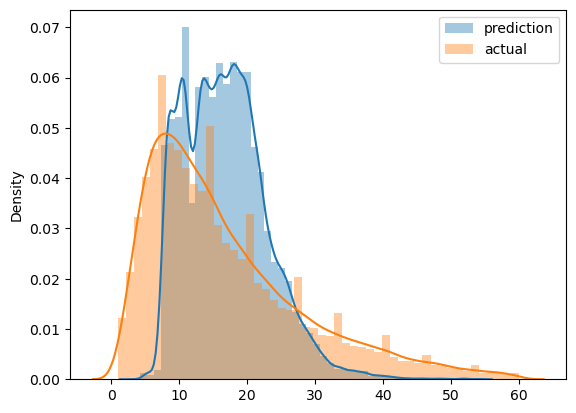

In [8]:
y_pred = lr.predict(X_train)

sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)

    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ["PU_DO"]
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715207656853

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Pepe")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

## Training an XGBoost model

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        return {'loss': rmse, 'status': STATUS_OK}

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) --> [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn = objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=Trials()
)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.88794                           
[1]	validation-rmse:6.83707                           
[2]	validation-rmse:6.58652                           
[3]	validation-rmse:6.51562                           
[4]	validation-rmse:6.47990                           
[5]	validation-rmse:6.47060                           
[6]	validation-rmse:6.45802                           
[7]	validation-rmse:6.45394                           
[8]	validation-rmse:6.44944                           
[9]	validation-rmse:6.43728                           
[10]	validation-rmse:6.43310                          
[11]	validation-rmse:6.42815                          
[12]	validation-rmse:6.42214                          
[13]	validation-rmse:6.41937                          
[14]	validation-rmse:6.41583                          
[15]	validation-rmse:6.41267                          
[16]	validation-rmse:6.41007                          
[17]	validation-rmse:6.40645                          
[18]	valid

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:30:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.56022                                                    
[1]	validation-rmse:7.25353                                                    
[2]	validation-rmse:6.82034                                                    
[3]	validation-rmse:6.66677                                                    
[4]	validation-rmse:6.60299                                                    
[5]	validation-rmse:6.56647                                                    
[6]	validation-rmse:6.54841                                                    
[7]	validation-rmse:6.53838                                                    
[8]	validation-rmse:6.53308                                                    
[9]	validation-rmse:6.52620                                                    
[10]	validation-rmse:6.52044                                                   
[11]	validation-rmse:6.51461                                                   
[12]	validation-rmse:6.51194            

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:31:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.44069                                                   
[1]	validation-rmse:10.76609                                                   
[2]	validation-rmse:10.17912                                                   
[3]	validation-rmse:9.67042                                                    
[4]	validation-rmse:9.23035                                                    
[5]	validation-rmse:8.85171                                                    
[6]	validation-rmse:8.52725                                                    
[7]	validation-rmse:8.24951                                                    
[8]	validation-rmse:8.01322                                                    
[9]	validation-rmse:7.81212                                                    
[10]	validation-rmse:7.64134                                                   
[11]	validation-rmse:7.49685                                                   
[12]	validation-rmse:7.37356            

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.39068                                                     
[1]	validation-rmse:6.76382                                                     
[2]	validation-rmse:6.64528                                                     
[3]	validation-rmse:6.61047                                                     
[4]	validation-rmse:6.58505                                                     
[5]	validation-rmse:6.57378                                                     
[6]	validation-rmse:6.56813                                                     
[7]	validation-rmse:6.56258                                                     
[8]	validation-rmse:6.56036                                                     
[9]	validation-rmse:6.55731                                                     
[10]	validation-rmse:6.55495                                                    
[11]	validation-rmse:6.55267                                                    
[12]	validation-rmse:6.55179

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:35:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.01954                                                   
[1]	validation-rmse:10.06423                                                   
[2]	validation-rmse:9.30382                                                    
[3]	validation-rmse:8.70811                                                    
[4]	validation-rmse:8.24501                                                    
[5]	validation-rmse:7.88705                                                    
[6]	validation-rmse:7.60986                                                    
[7]	validation-rmse:7.39683                                                    
[8]	validation-rmse:7.23355                                                    
[9]	validation-rmse:7.10702                                                    
[10]	validation-rmse:7.01166                                                   
[11]	validation-rmse:6.93382                                                   
[12]	validation-rmse:6.87650            

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:37:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.46953                                                   
[1]	validation-rmse:10.81569                                                   
[2]	validation-rmse:10.24297                                                   
[3]	validation-rmse:9.74355                                                    
[4]	validation-rmse:9.30816                                                    
[5]	validation-rmse:8.93125                                                    
[6]	validation-rmse:8.60556                                                    
[7]	validation-rmse:8.32506                                                    
[8]	validation-rmse:8.08345                                                    
[9]	validation-rmse:7.87665                                                    
[10]	validation-rmse:7.69951                                                   
[11]	validation-rmse:7.54771                                                   
[12]	validation-rmse:7.41913            

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:41:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.73029                                                     
[1]	validation-rmse:8.31519                                                     
[2]	validation-rmse:7.55451                                                     
[3]	validation-rmse:7.15187                                                     
[4]	validation-rmse:6.94059                                                     
[5]	validation-rmse:6.81966                                                     
[6]	validation-rmse:6.75130                                                     
[7]	validation-rmse:6.71407                                                     
[8]	validation-rmse:6.68889                                                     
[9]	validation-rmse:6.67344                                                     
[10]	validation-rmse:6.66296                                                    
[11]	validation-rmse:6.65417                                                    
[12]	validation-rmse:6.64877

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:42:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.92615                                                    
[1]	validation-rmse:9.91659                                                     
[2]	validation-rmse:9.13345                                                     
[3]	validation-rmse:8.53416                                                     
[4]	validation-rmse:8.07925                                                     
[5]	validation-rmse:7.73673                                                     
[6]	validation-rmse:7.47890                                                     
[7]	validation-rmse:7.28647                                                     
[8]	validation-rmse:7.14270                                                     
[9]	validation-rmse:7.03611                                                     
[10]	validation-rmse:6.95627                                                    
[11]	validation-rmse:6.89395                                                    
[12]	validation-rmse:6.84529

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:45:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.35667                                                     
[1]	validation-rmse:7.16191                                                     
[2]	validation-rmse:6.81235                                                     
[3]	validation-rmse:6.69483                                                     
[4]	validation-rmse:6.65249                                                     
[5]	validation-rmse:6.63016                                                     
[6]	validation-rmse:6.61770                                                     
[7]	validation-rmse:6.61271                                                     
[8]	validation-rmse:6.60737                                                     
[9]	validation-rmse:6.60023                                                     
[10]	validation-rmse:6.59200                                                    
[11]	validation-rmse:6.58845                                                    
[12]	validation-rmse:6.58462

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:46:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.42226                                                    
[1]	validation-rmse:9.15868                                                     
[2]	validation-rmse:8.28639                                                     
[3]	validation-rmse:7.69913                                                     
[4]	validation-rmse:7.30462                                                     
[5]	validation-rmse:7.04592                                                     
[6]	validation-rmse:6.87028                                                     
[7]	validation-rmse:6.75270                                                     
[8]	validation-rmse:6.66991                                                     
[9]	validation-rmse:6.61380                                                     
[10]	validation-rmse:6.57455                                                    
[11]	validation-rmse:6.54291                                                    
[12]	validation-rmse:6.52247

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:47:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.07386                                                    
[1]	validation-rmse:10.15149                                                    
[2]	validation-rmse:9.40924                                                     
[3]	validation-rmse:8.81828                                                     
[4]	validation-rmse:8.35187                                                     
[5]	validation-rmse:7.98631                                                     
[6]	validation-rmse:7.70095                                                     
[7]	validation-rmse:7.47903                                                     
[8]	validation-rmse:7.30759                                                     
[9]	validation-rmse:7.17399                                                     
[10]	validation-rmse:7.07052                                                    
[11]	validation-rmse:6.99046                                                    
[12]	validation-rmse:6.92737

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.28761                                                    
[1]	validation-rmse:9.00009                                                     
[2]	validation-rmse:8.16386                                                     
[3]	validation-rmse:7.63350                                                     
[4]	validation-rmse:7.29852                                                     
[5]	validation-rmse:7.08990                                                     
[6]	validation-rmse:6.95951                                                     
[7]	validation-rmse:6.87327                                                     
[8]	validation-rmse:6.81631                                                     
[9]	validation-rmse:6.77861                                                     
[10]	validation-rmse:6.75291                                                    
[11]	validation-rmse:6.73438                                                    
[12]	validation-rmse:6.71982

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:50:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.72722                                                     
[1]	validation-rmse:7.37088                                                     
[2]	validation-rmse:6.88272                                                     
[3]	validation-rmse:6.70210                                                     
[4]	validation-rmse:6.62158                                                     
[5]	validation-rmse:6.58334                                                     
[6]	validation-rmse:6.56462                                                     
[7]	validation-rmse:6.55128                                                     
[8]	validation-rmse:6.54452                                                     
[9]	validation-rmse:6.53995                                                     
[10]	validation-rmse:6.53521                                                    
[11]	validation-rmse:6.52976                                                    
[12]	validation-rmse:6.51861

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:50:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.73746                                                     
[1]	validation-rmse:6.63930                                                     
[2]	validation-rmse:6.62953                                                     
[3]	validation-rmse:6.61937                                                     
[4]	validation-rmse:6.61730                                                     
[5]	validation-rmse:6.61122                                                     
[6]	validation-rmse:6.60424                                                     
[7]	validation-rmse:6.59665                                                     
[8]	validation-rmse:6.58707                                                     
[9]	validation-rmse:6.58207                                                     
[10]	validation-rmse:6.57665                                                    
[11]	validation-rmse:6.57201                                                    
[12]	validation-rmse:6.56382

c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [09:51:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.85583                                                     
[1]	validation-rmse:6.90269                                                     
[2]	validation-rmse:6.68991                                                     
[3]	validation-rmse:6.61933                                                     
[4]	validation-rmse:6.58787                                                     
[5]	validation-rmse:6.57364                                                     
[6]	validation-rmse:6.56421                                                     
[7]	validation-rmse:6.55844                                                     
[8]	validation-rmse:6.55114                                                     
[9]	validation-rmse:6.54644                                                     
[10]	validation-rmse:6.54209                                                    
[11]	validation-rmse:6.53649                                                    
[12]	validation-rmse:6.53075

In [24]:
params = {
        'learning_rate': 0.22627054267337163,
        'max_depth': 54,
        'min_child_weight': 1.237730031241696,
        'objective': 'reg:linear',
        'reg_alpha': 0.12251950998015804,
        'reg_lambda': 0.02198973245162769,
        'seed': 42
    }

mlflow.xgboost.autolog()

booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )



2025/05/21 10:09:06 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/21 10:09:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f7af577127e44eab0068d4ba8ce4e6f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [10:09:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.42226
[1]	validation-rmse:9.15868
[2]	validation-rmse:8.28639
[3]	validation-rmse:7.69913
[4]	validation-rmse:7.30462
[5]	validation-rmse:7.04592
[6]	validation-rmse:6.87028
[7]	validation-rmse:6.75270
[8]	validation-rmse:6.66991
[9]	validation-rmse:6.61380
[10]	validation-rmse:6.57455
[11]	validation-rmse:6.54291
[12]	validation-rmse:6.52247
[13]	validation-rmse:6.50426
[14]	validation-rmse:6.49021
[15]	validation-rmse:6.47632
[16]	validation-rmse:6.46884
[17]	validation-rmse:6.46209
[18]	validation-rmse:6.45774
[19]	validation-rmse:6.45338
[20]	validation-rmse:6.45138
[21]	validation-rmse:6.44925
[22]	validation-rmse:6.44774
[23]	validation-rmse:6.44511
[24]	validation-rmse:6.44250
[25]	validation-rmse:6.43998
[26]	validation-rmse:6.43760
[27]	validation-rmse:6.43476
[28]	validation-rmse:6.43205
[29]	validation-rmse:6.43000
[30]	validation-rmse:6.42837
[31]	validation-rmse:6.42608
[32]	validation-rmse:6.42397
[33]	validation-rmse:6.42254
[34]	validation-rmse:6.

2025/05/21 10:11:34 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 10:11:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\cachu\anaconda3\envs\powerfull_gpu\lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [10:11:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 10:11:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
